# Evaluación de nuestro RAG

In [7]:
from langchain_mistralai import ChatMistralAI
from langchain_core.output_parsers import StrOutputParser
from langchain_ollama import OllamaEmbeddings, ChatOllama
from langchain_chroma import Chroma

from classes.chatbot import Chatbot

import pandas as pd
from tqdm import tqdm
import time
import warnings
from dotenv import load_dotenv
import os
import re

load_dotenv()
MISTRAL_API_KEY = os.getenv("MISTRAL_API_KEY")
warnings.filterwarnings("ignore", category=FutureWarning)

El modelo que vamos a usar para las evaluaciones y nuestro RAG

In [8]:
llm = ChatMistralAI(
    model="mistral-small-latest", 
    mistral_api_key=MISTRAL_API_KEY,
    temperature=0, 
    random_seed=12345
)

search_type = "similarity" # ["similarity", "mmr", "tfidf", "bm25", "grafo"]

chatbot = Chatbot(
    chroma_directory="chroma",  # directorio de la base de datos
    search_type=search_type,    # tipo de búsqueda en la base de datos
    k=6,                        # documentos recuperados de la base de datos
    top_n=3                     # documentos recuperados por el reranker
)

Cargamos una muestra de nuestro dataset

In [9]:
df = pd.read_csv("eval/test - preguntas_mistral_plus.csv", on_bad_lines="skip")
df_shuffle = df.sample(frac=1, random_state=12345)
test_sample = df_shuffle.head(50)
df_shuffle.head(10)

,Pregunta,Respuesta,Contexto,Recurso
209,¿Qué tipo de formación se financió con los Fon...,La formación financiada con los Fondos Next Ge...,ANEXO I Resoluciones del Servicio Público de E...,..\my_data\BOE-A-2024-26055.pdf
10,¿Hasta cuándo se extienden los plazos de prese...,Los plazos de presentación e ingreso de las de...,Artículo 7. Tramitación por el Consorcio de C...,..\my_data\BOE-A-2024-22928.pdf
300,¿Cuál es el número de identificación fiscal de...,S2800556I,BOLETÍN OFICIAL DEL ESTADO Núm. 37 Miércoles 1...,..\my_data\BOE-B-2025-4861.pdf
18,¿Cuál es el periodo en el que se aplica la exe...,La exención del 100 por ciento de la aportació...,periodos y porcentajes de jornada afectados po...,..\my_data\BOE-A-2024-22928.pdf
205,¿Quién fue nombrado Comisionado especial para ...,Don José María Ángel Batalla fue nombrado Comi...,"II. AUTORIDADES Y PERSONAL A. Nombramientos, s...",..\my_data\BOE-A-2024-25801.pdf
100,¿Estoy exento del pago de las cuotas del Impue...,"Sí, estás exento del pago de las cuotas del Im...",Cinco. Se da nueva redacción al apartado 1 del...,..\my_data\BOE-A-2024-23422.pdf
220,¿Puedo obtener financiación para renovar los a...,"Sí, podrás acogerte a la cobertura del aval pa...",2. Términos y condiciones aplicables al segund...,..\my_data\BOE-A-2024-26478.pdf
47,¿Qué medidas se han tomado para compensar la i...,Los operadores de comunicaciones electrónicas ...,temporal y por riesgo durante el embarazo y ri...,..\my_data\BOE-A-2024-23422.pdf
71,¿Qué documentos necesito para solicitar la dis...,Para solicitar la disposición anticipada de tu...,b) cuando sean trabajadores autónomos que se v...,..\my_data\BOE-A-2024-23422.pdf
20,¿Qué sucede con el tiempo de percepción de pre...,El tiempo en que se perciban prestaciones por ...,2. El tiempo en que se perciban prestaciones p...,..\my_data\BOE-A-2024-22928.pdf


## Configuración de los agentes críticos

- **Accuracy**: Grado de acierto de la respuesta final
- **Faithfulness**: Si la respuesta se basa exclusivamente en los documentos recuperados
- **Groundedness**: Si la pregunta puede ser respondida con el contexto aportado
- **Relevance**: Si los docs recuperados tienen que ver con la pregunta

In [10]:
accuracy_prompt = """
Tu tarea es evaluar la precisión de la respuesta generada comparándola con la respuesta esperada.

Criterios de evaluación:
5 - Exactamente igual en contenido y significado
4 - Pequeñas diferencias irrelevantes
3 - Contiene algunos errores menores pero el mensaje principal es correcto
2 - Diferencias significativas pero algo de información correcta
1 - Mínima relación con la respuesta esperada
0 - Totalmente incorrecta o contradictoria

Provee tu respuesta como sigue:

Respuesta:::
Rating: X

----
Respuesta esperada: {respuesta_esperada}\n
Respuesta generada: {respuesta_generada}\n
Respuesta:::
"""

faithfulness_prompt = """
Tu tarea es evaluar si la respuesta usa SOLO información de los documentos.

Criterios:
5 - Totalmente basada en los documentos (sin añadidos)
4 - Principalmente basada, con frases genéricas inocuas
3 - Incluye inferencias razonables no explícitas
2 - Mezcla información documentada con suposiciones
1 - Mayormente inventada pero con algún detalle relevante
0 - Totalmente inventada o irrelevante

Provee tu respuesta como sigue:

Respuesta:::
Rating: X

Respuesta:::
Rating: (tu rating, como número del 0 al 5)

Aqui tienes los documentos recuperados y la respuesta generada por el sistema RAG.

Documentos recuperados: {documentos}\n
Respuesta generada: {respuesta}\n
Respuesta:::
"""

groundedness_prompt = """
Tu tarea es evaluar cómo de bien la respuesta usa la evidencia de los documentos.

Criterios:
5 - Usa múltiples evidencias clave de forma precisa
4 - Usa al menos una evidencia clave correctamente
3 - Menciona los documentos pero de forma vaga
2 - Uso superficial o poco relevante de los documentos
1 - Cita documentos incorrectamente
0 - Ignora por completo los documentos

Provee tu respuesta como sigue:

Respuesta:::
Rating: (tu rating, como número del 0 al 5)

Aqui tienes los documentos recuperados y la respuesta generada por el sistema RAG.

Documentos recuperados: {documentos}\n
Respuesta generada: {respuesta}\n
Respuesta:::
"""

relevance_prompt = """
Tu tarea es evaluar qué tan relevantes son los documentos para responder la pregunta.

Criterios:
5 - Abordan directamente el núcleo de la pregunta
4 - Cubren aspectos importantes pero no todos
3 - Proporcionan contexto general útil
2 - Tienen conexión tangencial con el tema
1 - Mínima relación con la pregunta
0 - Completamente irrelevantes

Provee tu respuesta como sigue:

Aquí tienes la pregunta y los documentos recuperados.

Respuesta:::
Rating: (tu rating, como número del 0 al 5)

Pregunta: {pregunta}\n
Respuesta esperada: {respuesta}\n
Documentos recuperados: {documentos}\n
Respuesta:::
"""

In [11]:
def get_response(question: str, chatbot: Chatbot):
    results = chatbot.get_retriever().invoke(question)
    context = "\n\n---\n\n".join([doc.page_content for doc in results]) 
    
    response = chatbot.answer_query2(question, context)

    return response, context

def get_response_reranker(question: str, chatbot: Chatbot):
    results = chatbot.get_compression_retriever().invoke(question)
    context = "\n\n---\n\n".join([doc.page_content for doc in results]) 
    
    response = chatbot.answer_query2(question, context)

    return response, context

Evaluación del RAG + Reranking

In [12]:
columns = [
    "pregunta", "respuesta esperada", "respuesta generada", 
    "accuracy", "faithfulness", 
    "groundedness", "relevance"
]

eval_rag = []
eval_rag_rr = []

sleep = 2

for index, row in tqdm(test_sample.iterrows(), desc="Evaluando el RAG", total=len(test_sample), unit="pregunta"):
    pregunta = row["Pregunta"]
    respuesta = row["Respuesta"]
    contexto = row["Contexto"]       

    ### NORMAL ###

    time.sleep(sleep) # Espera para evitar sobrecargar el servidor
    respuesta_generada, docs_recuperados = get_response(pregunta, chatbot)  
    # print(docs_recuperados)

    evaluations = {
        "accuracy": accuracy_prompt.format(respuesta_esperada=respuesta, respuesta_generada=respuesta_generada),
        "faithfulness": faithfulness_prompt.format(documentos=docs_recuperados, respuesta=respuesta_generada),
        "groundedness": groundedness_prompt.format(documentos=docs_recuperados, respuesta=respuesta_generada),
        "relevance": relevance_prompt.format(pregunta=pregunta, respuesta=respuesta, documentos=docs_recuperados)
    }        


    ### RERANKING ###
    time.sleep(sleep)
    respuesta_generada_rr, docs_recuperados_rr = get_response_reranker(pregunta, chatbot)   
    # print(docs_recuperados)

    evaluations_rr = {
        "accuracy": accuracy_prompt.format(respuesta_esperada=respuesta, respuesta_generada=respuesta_generada_rr),
        "faithfulness": faithfulness_prompt.format(documentos=docs_recuperados_rr, respuesta=respuesta_generada_rr),
        "groundedness": groundedness_prompt.format(documentos=docs_recuperados_rr, respuesta=respuesta_generada_rr),
        "relevance": relevance_prompt.format(pregunta=pregunta, respuesta=respuesta, documentos=docs_recuperados_rr)
    } 

    try:

        eval_row = {
            "pregunta": pregunta,
            "respuesta esperada": respuesta,
            "respuesta generada": respuesta_generada            
        }
        for criterion, evaluation in evaluations.items():
            time.sleep(sleep) 
            chain = llm | StrOutputParser()
            response = chain.invoke(evaluation)
            match = re.search(r'Rating:\s*(\d+)', response)
            score = int(match.group(1))
            eval_row[criterion] = score
        eval_rag.append(eval_row)

        #####################

        eval_row_rr = {
            "pregunta": pregunta,
            "respuesta esperada": respuesta,
            "respuesta generada": respuesta_generada_rr            
        }
        for criterion, evaluation in evaluations_rr.items():
            time.sleep(sleep) 
            chain = llm | StrOutputParser()
            response = chain.invoke(evaluation)
            match = re.search(r'Rating:\s*(\d+)', response)
            score = int(match.group(1))
            eval_row_rr[criterion] = score
        eval_rag_rr.append(eval_row_rr)
            
    except Exception as e:
        continue

Evaluando el RAG: 100%|██████████| 50/50 [36:50<00:00, 44.22s/pregunta]


In [13]:
eval_rag_df = pd.DataFrame(eval_rag, columns=columns)
eval_rag_df.to_csv(f"eval/eval_{search_type}.csv", index=False)

print("Resultados RAG")
eval_rag_df.head(10)

Resultados RAG


,pregunta,respuesta esperada,respuesta generada,accuracy,faithfulness,groundedness,relevance
0,¿Qué tipo de formación se financió con los Fon...,La formación financiada con los Fondos Next Ge...,"Con los Fondos Next Generation EU, se financió...",3,5,4,5
1,¿Hasta cuándo se extienden los plazos de prese...,Los plazos de presentación e ingreso de las de...,Los plazos de presentación e ingreso de declar...,3,5,5,2
2,¿Cuál es el número de identificación fiscal de...,S2800556I,El número de identificación fiscal de la Direc...,4,5,4,5
3,¿Cuál es el periodo en el que se aplica la exe...,La exención del 100 por ciento de la aportació...,La exención del 100 por ciento de la aportació...,2,5,5,2
4,¿Quién fue nombrado Comisionado especial para ...,Don José María Ángel Batalla fue nombrado Comi...,No lo sé.,0,0,0,2
5,¿Estoy exento del pago de las cuotas del Impue...,"Sí, estás exento del pago de las cuotas del Im...","Sí, estás exento del pago de las cuotas del Im...",3,5,4,5
6,¿Puedo obtener financiación para renovar los a...,"Sí, podrás acogerte a la cobertura del aval pa...","Sí, puedes obtener financiación para renovar l...",3,5,5,5
7,¿Qué medidas se han tomado para compensar la i...,Los operadores de comunicaciones electrónicas ...,Para compensar la interrupción de los servicio...,3,5,5,5
8,¿Qué documentos necesito para solicitar la dis...,Para solicitar la disposición anticipada de tu...,No lo sé.,0,0,0,2
9,¿Qué sucede con el tiempo de percepción de pre...,El tiempo en que se perciban prestaciones por ...,El tiempo de percepción de prestaciones por ce...,1,5,4,3


In [14]:
eval_rag_df_rr = pd.DataFrame(eval_rag_rr, columns=columns)
eval_rag_df_rr.to_csv(f"eval/eval_{search_type}_rr.csv", index=False)

print("Resultados RAG + rerank")
eval_rag_df_rr.head(10)

Resultados RAG + rerank


,pregunta,respuesta esperada,respuesta generada,accuracy,faithfulness,groundedness,relevance
0,¿Qué tipo de formación se financió con los Fon...,La formación financiada con los Fondos Next Ge...,"Tras la DANA, los Fondos Next Generation EU fi...",3,3,4,4
1,¿Hasta cuándo se extienden los plazos de prese...,Los plazos de presentación e ingreso de las de...,Los plazos de presentación e ingreso de declar...,2,5,5,5
2,¿Cuál es el número de identificación fiscal de...,S2800556I,El número de identificación fiscal de la Direc...,4,5,4,5
3,¿Cuál es el periodo en el que se aplica la exe...,La exención del 100 por ciento de la aportació...,El periodo en el que se aplica la exención del...,2,3,4,3
4,¿Quién fue nombrado Comisionado especial para ...,Don José María Ángel Batalla fue nombrado Comi...,No lo sé.,0,0,0,3
5,¿Estoy exento del pago de las cuotas del Impue...,"Sí, estás exento del pago de las cuotas del Im...","Sí, estás exento del pago de las cuotas del Im...",3,5,4,5
6,¿Puedo obtener financiación para renovar los a...,"Sí, podrás acogerte a la cobertura del aval pa...","Sí, puedes obtener financiación para renovar l...",3,5,5,5
7,¿Qué medidas se han tomado para compensar la i...,Los operadores de comunicaciones electrónicas ...,Para compensar la interrupción de los servicio...,4,5,5,5
8,¿Qué documentos necesito para solicitar la dis...,Para solicitar la disposición anticipada de tu...,No lo sé.,0,0,0,2
9,¿Qué sucede con el tiempo de percepción de pre...,El tiempo en que se perciban prestaciones por ...,El tiempo de percepción de prestaciones por ce...,1,4,5,3


In [15]:
scores_columns = ["accuracy", "faithfulness", "groundedness", "relevance"]

print("Puntuación RAG")
scores_df = round(eval_rag_df[scores_columns].mean(),2)
scores_df = scores_df.to_frame().transpose()
scores_df


Puntuación RAG


,accuracy,faithfulness,groundedness,relevance
0,2.49,3.88,3.95,3.81


In [16]:
print("Puntuación RAG + rerank")
scores_df_rr = round(eval_rag_df_rr[scores_columns].mean(),2)
scores_df_rr = scores_df_rr.to_frame().transpose()
scores_df_rr

Puntuación RAG + rerank


,accuracy,faithfulness,groundedness,relevance
0,2.5,4.02,4.07,4.14


# Representación

In [17]:
%matplotlib inline

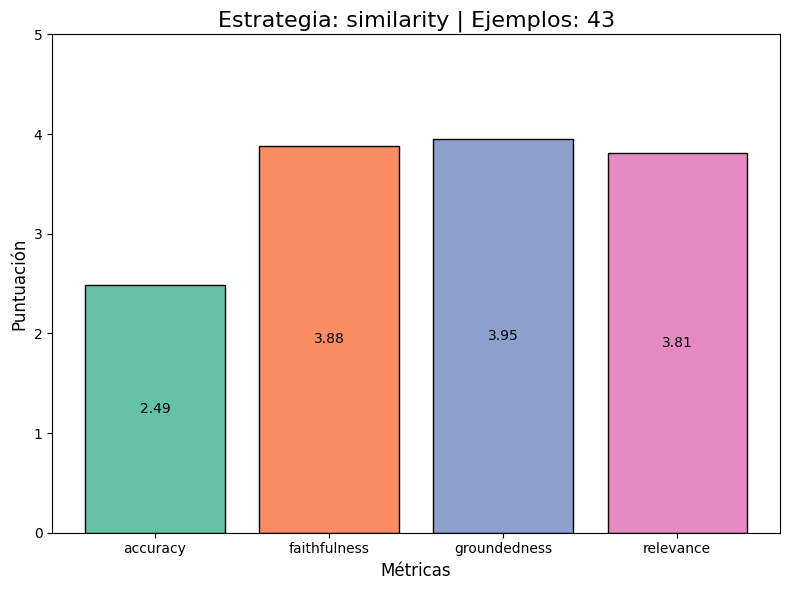

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Transponer el DataFrame para facilitar el plot
data = scores_df.transpose()
data.columns = ["Puntuación"]

# Colores distintos para cada barra
colors = sns.color_palette("Set2", n_colors=len(data))

# Crear la figura
plt.figure(figsize=(8, 6))

# Crear el gráfico de barras
bars = plt.bar(data.index, data["Puntuación"], color=colors, edgecolor='black')

# Añadir etiquetas centradas dentro de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height / 2,
        f"{height:.2f}",
        ha='center',
        va='center',
        fontsize=10,
        color='black'
    )

num_rows = len(eval_rag_df)

# Personalizar la gráfica
plt.title(f"Estrategia: {search_type} | Ejemplos: {num_rows}", fontsize=16)
plt.xlabel("Métricas", fontsize=12)
plt.ylabel("Puntuación", fontsize=12)
plt.ylim(0, 5)
plt.xticks(rotation=0)  
plt.tight_layout()

# Guardar y mostrar la gráfica
plt.savefig(f"images/eval_{search_type}_2.png", dpi=300, bbox_inches="tight")
plt.show()



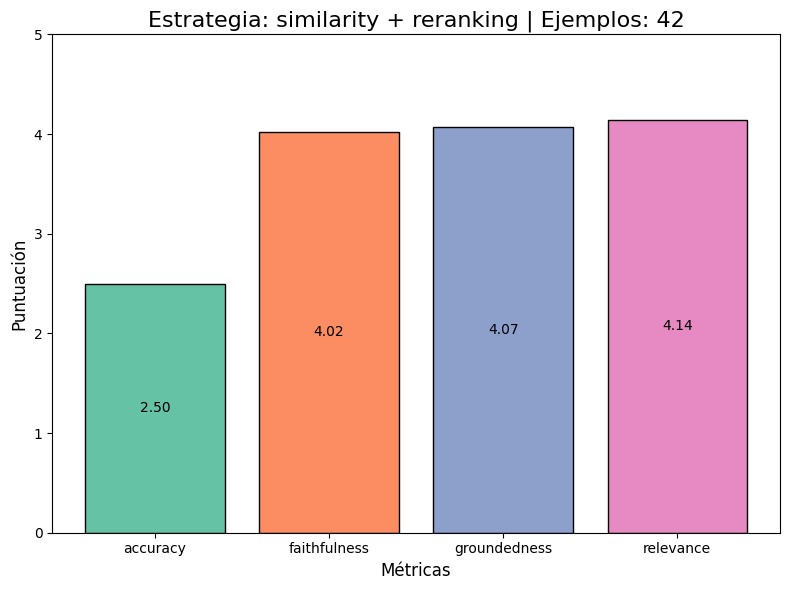

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Transponer el DataFrame para facilitar el plot
data = scores_df_rr.transpose()
data.columns = ["Puntuación"]

# Colores distintos para cada barra
colors = sns.color_palette("Set2", n_colors=len(data))

# Crear la figura
plt.figure(figsize=(8, 6))

# Crear el gráfico de barras
bars = plt.bar(data.index, data["Puntuación"], color=colors, edgecolor='black')

# Añadir etiquetas centradas dentro de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height / 2,
        f"{height:.2f}",
        ha='center',
        va='center',
        fontsize=10,
        color='black'
    )

num_rows = len(eval_rag_df_rr)

# Personalizar la gráfica
plt.title(f"Estrategia: {search_type} + reranking | Ejemplos: {num_rows}", fontsize=16)
plt.xlabel("Métricas", fontsize=12)
plt.ylabel("Puntuación", fontsize=12)
plt.ylim(0, 5)
plt.xticks(rotation=0)  
plt.tight_layout()

# Guardar y mostrar la gráfica
plt.savefig(f"images/eval_{search_type}_2_rr.png", dpi=300, bbox_inches="tight")
plt.show()